In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import random
import seaborn as sns
import pandas as pd
import pickle
import math
import torchaudio

from torchaudio.transforms import TimeMasking, FrequencyMasking
from torchvision.ops import SqueezeExcitation
from torchinfo import summary
from torchsummary import summary
from torchvision.ops import SqueezeExcitation
from tqdm import tqdm
from torchvision import datasets, transforms
from collections import defaultdict
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
from functools import reduce
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

pd.set_option('future.no_silent_downcasting', True)

c:\Users\user\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading data

In [2]:
keys_s = '0123456789abcdefghijklmnopqrstuvwxyz'
labels = list(keys_s)
keys = [k + '.wav' for k in labels]
data_dict = {'Key':[], 'File':[]}

In [3]:
def isolator(signal, sample_rate, size, scan, before, after, threshold, show=False):
    strokes = []
    # -- signal'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(signal, sr=sample_rate)
    fft = librosa.stft(signal, n_fft=size, hop_length=scan)
    energy = np.abs(np.sum(fft, axis=0)).astype(float)
    # norm = np.linalg.norm(energy)
    # energy = energy/norm
    # -- energy'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(energy)
    threshed = energy > threshold
    # -- peaks'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(threshed.astype(float))
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*scan) + size//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            strokes.append(torch.tensor(keystroke)[None, :])
            if show:
                plt.figure(figsize=(7, 2))
                librosa.display.waveshow(keystroke, sr=sample_rate)
            prev_end = timestamp+after
    return strokes

def convert_to_df(AUDIO_FILE):
    for i, File in enumerate(keys):
        loc = AUDIO_FILE + File
        samples, sample_rate = librosa.load(loc, sr=None)
        #samples = samples[round(1*sample_rate):]
        strokes = []
        prom = 0.06
        step = 0.005
        while not len(strokes) == 25:
            strokes = isolator(samples[1*sample_rate:], sample_rate, 48, 24, 2400, 12000, prom, False)
            if len(strokes) < 25:
                prom -= step
            if len(strokes) > 25:
                prom += step
            if prom <= 0:
                print('-- not possible for: ',File)
                break
            step = step*0.99
        label = [labels[i]]*len(strokes)
        data_dict['Key'] += label
        data_dict['File'] += strokes

    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0
    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace=True)
    return df, sample_rate 

In [4]:
data_frame, sr = convert_to_df("../../dataset/Zoom/")

print(data_frame.head())
print(data_frame.info())

  Key                                               File
0   0  [[tensor(-6.1035e-05), tensor(-6.1035e-05), te...
1   0  [[tensor(0.), tensor(-3.0518e-05), tensor(-3.0...
2   0  [[tensor(3.0518e-05), tensor(3.0518e-05), tens...
3   0  [[tensor(-0.0002), tensor(-0.0002), tensor(-0....
4   0  [[tensor(6.1035e-05), tensor(6.1035e-05), tens...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Key     900 non-null    object
 1   File    900 non-null    object
dtypes: object(2)
memory usage: 14.2+ KB
None


In [5]:
train_set, tmp_set = train_test_split(data_frame, test_size=0.3, stratify=data_frame['Key'])
val_set, test_set = train_test_split(tmp_set, test_size=0.33, stratify=tmp_set['Key'])

print("Sample rate:", sr)
print(len(train_set), len(val_set), len(test_set))

Sample rate: 32000
630 180 90


### Data augmentation setup

In [6]:
class MyDataset(Dataset):
    def __init__(self, file_name, transform = None, aug = None):
        df = file_name
        self.transform = transform
        self.aug = aug
        self.labels = df['Key']
        self.values = df['File']
        
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        label = self.labels.iloc[index]
        value = self.values.iloc[index]
        waveform = self.values.iloc[index]
        label = self.labels.iloc[index]
        if self.transform:
            waveform = waveform.numpy()
            waveform = waveform.flatten()
            waveform = self.transform(waveform)
        if self.aug:
            waveform = self.aug(waveform)
        return waveform, label

class ToMelSpectrogram:
    def __call__(self, samples):
#         samples = np.array(samples)
        spec = librosa.feature.melspectrogram(y = samples, sr = sr, n_mels=64, n_fft=2048, win_length=1024, hop_length=226)
        return librosa.power_to_db(spec)

class TimeShifting():
    def __call__(self, samples):
        samples = samples.numpy()
        samples = samples.flatten()
        
        shift = int(len(samples) * 0.4)
        random_shift =random.randint(0, shift)
        data_roll = np.roll(samples, random_shift)
        return data_roll
    
class SpecAugment():
    def __call__(self, samples):
        num_mask = 2
        freq_masking_max_percentage=0.10
        time_masking_max_percentage=0.10
        spec = samples.copy()
        mean_value = spec.mean()
        for i in range(num_mask):
            all_frames_num, all_freqs_num = spec.shape[1], spec.shape[1] 
            freq_percentage = random.uniform(0.0, freq_masking_max_percentage)

            num_freqs_to_mask = int(freq_percentage * all_freqs_num)
            f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
            f0 = int(f0)
            spec[:, f0:f0 + num_freqs_to_mask] = mean_value

            time_percentage = random.uniform(0.0, time_masking_max_percentage)

            num_frames_to_mask = int(time_percentage * all_frames_num)
            t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
            t0 = int(t0)
            spec[t0:t0 + num_frames_to_mask, :] = mean_value
        return spec

aug = Compose([
    TimeShifting(),
    ToMelSpectrogram(),
    SpecAugment(),
    ToTensor()
    ])

transform = Compose([
    ToMelSpectrogram(),
    ToTensor()])
        
train_set = MyDataset(train_set, aug = aug)
val_set = MyDataset(val_set, transform = transform)
test_set = MyDataset(test_set, transform = transform)

### Training set image (augmented vs non-augmented)

torch.Size([64, 64])


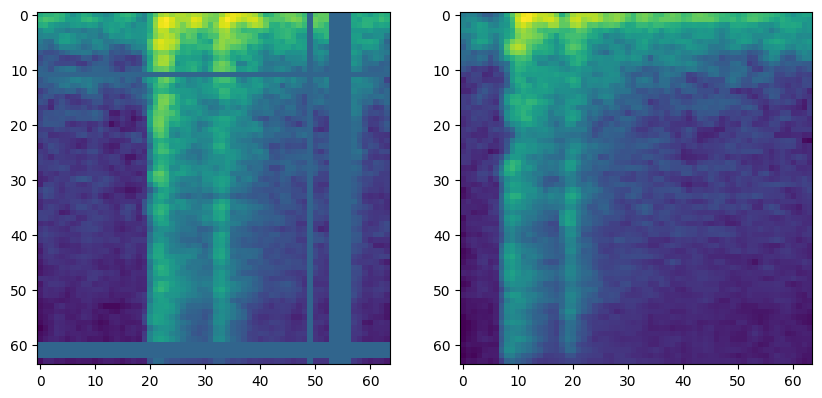

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(train_set[0][0][0], cmap='viridis')
ax2.imshow(val_set[0][0][0], cmap='viridis')
print(train_set[0][0][0].shape)
ax1.grid(False)
ax2.grid(False)
plt.show()

In [8]:
print("number of classes:", len(np.unique(data_frame['Key'])))

number of classes: 36


### CoAtNet (Model)

In [9]:
class Stem(nn.Sequential):
    def __init__(self, out_channels):
        super().__init__(
            nn.Conv2d(1, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3)
        )

In [10]:
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__()
        self.mb_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            nn.Conv2d(in_channels * expansion_factor, in_channels * expansion_factor, kernel_size=3, padding=1, groups=in_channels * expansion_factor),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            SqueezeExcitation(in_channels * expansion_factor, in_channels, activation=nn.GELU),
            nn.Conv2d(in_channels * expansion_factor, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        return x + self.mb_conv(x)

In [11]:
class DownsamplingMBConv(MBConv):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__(in_channels, out_channels, expansion_factor=4)
        self.mb_conv[1] = nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1, stride = 2)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.mb_conv(x)

In [12]:
class RelativeAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__()
        heads = out_channels // head_size
        self.heads = heads
        self.head_size = head_size
        self.image_size = image_size
        self.head_dim = heads * head_size
        self.attend = nn.Softmax(dim=-2) # Taken from My_CoAtNet
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.to_q = nn.Linear(in_channels, self.head_dim)
        self.to_k = nn.Linear(in_channels, self.head_dim)
        self.to_v = nn.Linear(in_channels, self.head_dim)
        self.to_output = nn.Sequential(
            nn.Linear(self.head_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(in_channels)
        
        self.relative_bias = nn.Parameter(torch.randn(heads, (2 * image_size - 1) * (2 * image_size - 1)))
        self.register_buffer("relative_indices", self.get_indices(image_size, image_size)) # Taken from My_CoAtNet
        self.precomputed_relative_bias = None
    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def get_relative_biases(self):
        # Relative bias caching mentioned in CoAtNet: Marrying Convolution and Attention for All Data Sizes
        if not self.training:
            return self.precomputed_relative_bias
        # Taken from od My_CoAtNet
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.relative_bias.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (self.image_size * self.image_size, self.image_size * self.image_size))
        return rel_pos_enc
    
    def reshape_for_linear(self, x):
        b, _, _, _ = x.shape
        return x.reshape(b, self.image_size * self.image_size, self.in_channels)
    
    def attention_score(self, x):
        b, _, h, _ = x.shape
        q = self.to_q(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        k = self.to_k(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        dots = torch.matmul(k.transpose(-1, -2), q) / math.sqrt(self.head_dim)
        relative_biases_indexed = self.get_relative_biases()
        return self.attend(dots + relative_biases_indexed)
    
    def relative_attention(self, x):
        b, _, _, _ = x.shape
        v = self.to_v(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        out = torch.matmul(v, self.attention_score(x)) # I figured this out after debugging (Still the same as My_CoAtNet)
        out = out.view(b, self.image_size, self.image_size, -1)
        return self.to_output(out).view(b, self.out_channels, self.image_size, self.image_size)
        
    def forward(self, x):
        return x + self.relative_attention(self.norm(x))
    
    def train(self, training):
        if not training:
            self.precomputed_relative_bias = self.get_relative_biases()
        super().train(training)
        
    # Taken from My_CoAtNet
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x)
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices
        

In [13]:
class DownsamplingRelativeAttention2d(RelativeAttention2d):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__(in_channels, out_channels, image_size, heads=8, head_size=32)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.normalization = nn.LayerNorm(in_channels)


    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
        
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.relative_attention(self.pool(self.norm(x)))

In [14]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, out_channels, expansion_factor=4):
        super().__init__()
        hidden_dim = out_channels * expansion_factor
        self.ffn = nn.Sequential(
            nn.Linear(out_channels, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(out_channels)
        self.out_channels = out_channels

    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def forward(self, x):
        old_shape = x.shape
        batch_size = old_shape[0]
        return x + torch.reshape(self.ffn(torch.reshape(self.norm(x), (batch_size, -1, self.out_channels))), old_shape)
    

In [15]:
class DownsampleTransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = DownsamplingRelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [16]:
class TransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = RelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [17]:
class Head(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)
        self.in_channels = in_channels
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool(x)
        x = torch.reshape(x, (batch_size, -1, self.in_channels))
        return torch.squeeze(self.fc(x))
    

In [18]:
class MyCoAtNet(nn.Sequential):
    def __init__(self, nums_blocks, layer_out_channels, num_classes=36):
        s0 = nn.Sequential(Stem(layer_out_channels[0]))
        
        s1 = [DownsamplingMBConv(layer_out_channels[0], layer_out_channels[1])]
        for i in range(nums_blocks[1] - 1):
            s1.append(MBConv(layer_out_channels[1], layer_out_channels[1]))
        s1 = nn.Sequential(*s1)
        
        s2 = [DownsamplingMBConv(layer_out_channels[1], layer_out_channels[2])]
        for i in range(nums_blocks[2] - 1):
            s2.append(MBConv(layer_out_channels[2], layer_out_channels[2]))
        s2 = nn.Sequential(*s2)
        
        s3 = [DownsampleTransformerBlock(layer_out_channels[2], layer_out_channels[3], 64 // 16)]
        for i in range(nums_blocks[3] - 1):
            s3.append(TransformerBlock(layer_out_channels[3], layer_out_channels[3], 64 // 16))
        s3 = nn.Sequential(*s3)
        
        s4 = [DownsampleTransformerBlock(layer_out_channels[3], layer_out_channels[4], 64 // 32)]
        for i in range(nums_blocks[4] - 1):
            s4.append(TransformerBlock(layer_out_channels[4], layer_out_channels[4], 64 // 32))
        s4 = nn.Sequential(*s4)
        
        head = Head(layer_out_channels[4], num_classes)
        
        super().__init__(
            s0,
            s1,
            s2,
            s3,
            s4,
            head
        )
            

In [19]:
# CoAtNet-1
nums_blocks = [2, 2, 3, 5, 2]           # L
channels = [64, 96, 192, 384, 768]      # D

model = MyCoAtNet(nums_blocks, channels)

c:\Users\user\miniconda3\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [20]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.apply(init_linear)
model.to(device)

print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

summary(model, input_size=(1, 64, 64))

Number of parameters: 24,033,296
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              GELU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 30, 30]          36,928
         MaxPool2d-5           [-1, 64, 15, 15]               0
            Conv2d-6           [-1, 96, 15, 15]           6,144
       BatchNorm2d-7           [-1, 64, 30, 30]             128
            Conv2d-8          [-1, 256, 15, 15]          16,640
       BatchNorm2d-9          [-1, 256, 15, 15]             512
             GELU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]           2,560
      BatchNorm2d-12          [-1, 256, 15, 15]             512
             GELU-13          [-1, 256, 15, 15]               0
Adapti

### Training

In [22]:
train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_set,
    batch_size=16,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=16,
    shuffle=True
)

In [23]:
# Adapted from My_CoAtNet
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.LayerNorm, nn.BatchNorm2d)
    
    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [24]:
cost = torch.nn.CrossEntropyLoss()

learning_rate = 5e-4
weight_decay = 0.1
num_epochs = 1100
min_learning_rate = 1e-6

param_dict = {pn: p for pn, p in model.named_parameters()}
parameters_decay, parameters_no_decay = separate_parameters(model)
parameter_groups = [
    {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
    {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
]
optimizer = torch.optim.Adam(parameter_groups, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=min_learning_rate / learning_rate, total_iters=num_epochs)

In [25]:
# Adapted from My_CoAtNet
def plot_results(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.title("Loss")
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(["Training loss", "Validation loss"], loc =  "best")
    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(train_accuracies)
    plt.plot(val_accuracies)
    plt.legend(["Training accuracy", "Validation accuracy"], loc =  "best")
    plt.show()

In [26]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [27]:
best_model_path = "CoAtNet-1-Best-Zoom.pkl"
model_path = "CoAtNet-1-Zoom.pkl"

Epoch [1/1100], Loss: 17.263992309570312, Accuracy: 0.03492063492063492 Correct: 22 Total: 630 LR: 0.0005 -> 0.0004995463636363637
Validation Accuracy: 0.044444444444444446 Validation loss: 12.541327476501465 Correct: 8 Total: 180
Epoch [2/1100], Loss: 8.788792610168457, Accuracy: 0.07777777777777778 Correct: 49 Total: 630 LR: 0.0004995463636363637 -> 0.0004990927272727273
Validation Accuracy: 0.10555555555555556 Validation loss: 14.746855735778809 Correct: 19 Total: 180
Epoch [3/1100], Loss: 10.092728614807129, Accuracy: 0.09206349206349207 Correct: 58 Total: 630 LR: 0.0004990927272727273 -> 0.000498639090909091
Validation Accuracy: 0.08888888888888889 Validation loss: 8.761749267578125 Correct: 16 Total: 180
Epoch [4/1100], Loss: 5.286815166473389, Accuracy: 0.10952380952380952 Correct: 69 Total: 630 LR: 0.000498639090909091 -> 0.0004981854545454546
Validation Accuracy: 0.1388888888888889 Validation loss: 2.0555171966552734 Correct: 25 Total: 180
Epoch [5/1100], Loss: 4.4940133094787

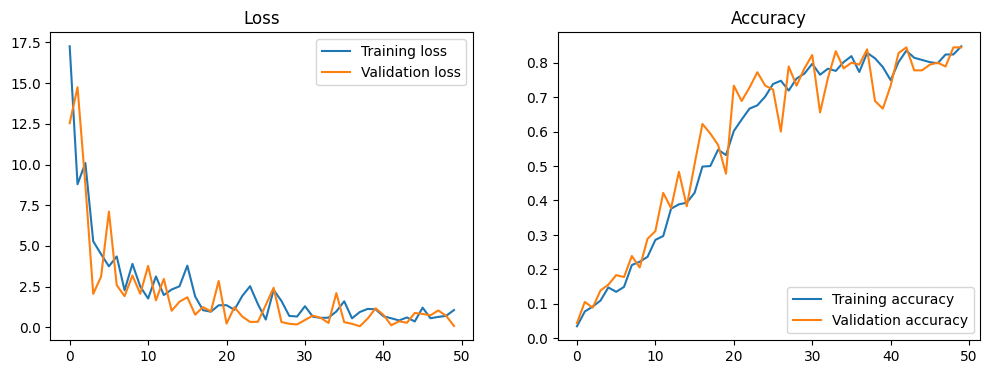

Epoch [51/1100], Loss: 1.2361388206481934, Accuracy: 0.8142857142857143 Correct: 513 Total: 630 LR: 0.0004773181818181822 -> 0.0004768645454545458
Validation Accuracy: 0.7944444444444444 Validation loss: 1.0490916967391968 Correct: 143 Total: 180
Epoch [52/1100], Loss: 0.33841672539711, Accuracy: 0.8063492063492064 Correct: 508 Total: 630 LR: 0.0004768645454545458 -> 0.0004764109090909094
Validation Accuracy: 0.7888888888888889 Validation loss: 0.3994572162628174 Correct: 142 Total: 180
Epoch [53/1100], Loss: 0.9805264472961426, Accuracy: 0.8396825396825397 Correct: 529 Total: 630 LR: 0.0004764109090909094 -> 0.00047595727272727305
Validation Accuracy: 0.5555555555555556 Validation loss: 1.2898986339569092 Correct: 100 Total: 180
Epoch [54/1100], Loss: 0.3086090087890625, Accuracy: 0.8444444444444444 Correct: 532 Total: 630 LR: 0.00047595727272727305 -> 0.0004755036363636367
Validation Accuracy: 0.8388888888888889 Validation loss: 0.9537440538406372 Correct: 151 Total: 180
Epoch [55/11

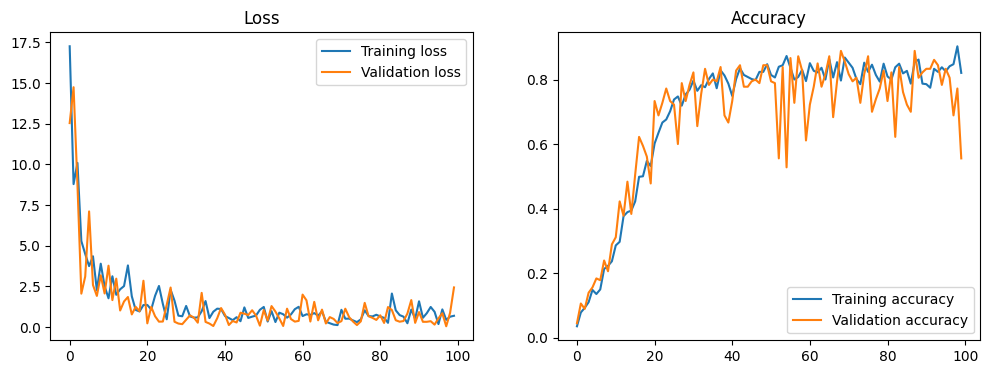

Epoch [101/1100], Loss: 0.8390340209007263, Accuracy: 0.8444444444444444 Correct: 532 Total: 630 LR: 0.0004546363636363642 -> 0.00045418272727272785
Validation Accuracy: 0.8222222222222222 Validation loss: 0.8721781969070435 Correct: 148 Total: 180
Epoch [102/1100], Loss: 1.768038272857666, Accuracy: 0.8174603174603174 Correct: 515 Total: 630 LR: 0.00045418272727272785 -> 0.0004537290909090915
Validation Accuracy: 0.85 Validation loss: 0.22107338905334473 Correct: 153 Total: 180
Epoch [103/1100], Loss: 0.6723869442939758, Accuracy: 0.8603174603174604 Correct: 542 Total: 630 LR: 0.0004537290909090915 -> 0.0004532754545454551
Validation Accuracy: 0.7777777777777778 Validation loss: 0.6045241355895996 Correct: 140 Total: 180
Epoch [104/1100], Loss: 1.255149006843567, Accuracy: 0.8333333333333334 Correct: 525 Total: 630 LR: 0.0004532754545454551 -> 0.00045282181818181874
Validation Accuracy: 0.8555555555555555 Validation loss: 0.2113366425037384 Correct: 154 Total: 180
Epoch [105/1100], Lo

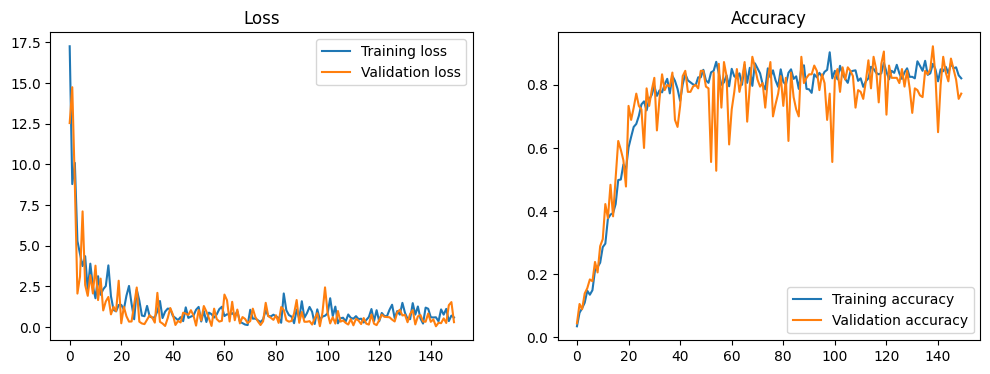

Epoch [151/1100], Loss: 0.25456222891807556, Accuracy: 0.846031746031746 Correct: 533 Total: 630 LR: 0.0004319545454545459 -> 0.0004315009090909095
Validation Accuracy: 0.9 Validation loss: 0.3491300642490387 Correct: 162 Total: 180
Epoch [152/1100], Loss: 0.5864506959915161, Accuracy: 0.8793650793650793 Correct: 554 Total: 630 LR: 0.0004315009090909095 -> 0.0004310472727272731
Validation Accuracy: 0.8444444444444444 Validation loss: 0.09884660691022873 Correct: 152 Total: 180
Epoch [153/1100], Loss: 0.8152663707733154, Accuracy: 0.8476190476190476 Correct: 534 Total: 630 LR: 0.0004310472727272731 -> 0.00043059363636363676
Validation Accuracy: 0.8722222222222222 Validation loss: 0.032040588557720184 Correct: 157 Total: 180
Epoch [154/1100], Loss: 0.21885772049427032, Accuracy: 0.8507936507936508 Correct: 536 Total: 630 LR: 0.00043059363636363676 -> 0.0004301400000000004
Validation Accuracy: 0.8388888888888889 Validation loss: 0.257831335067749 Correct: 151 Total: 180
Epoch [155/1100], 

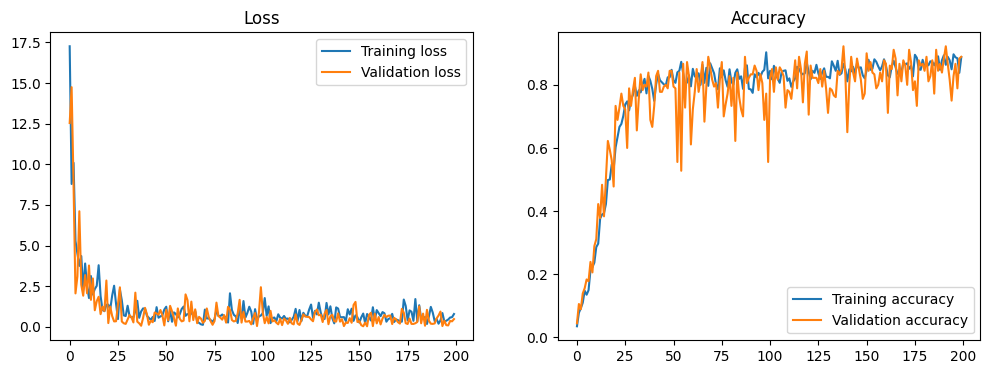

Epoch [201/1100], Loss: 0.5336018800735474, Accuracy: 0.8746031746031746 Correct: 551 Total: 630 LR: 0.00040927272727272774 -> 0.0004088190909090914
Validation Accuracy: 0.8555555555555555 Validation loss: 0.9252036213874817 Correct: 154 Total: 180
Epoch [202/1100], Loss: 1.268884539604187, Accuracy: 0.9063492063492063 Correct: 571 Total: 630 LR: 0.0004088190909090914 -> 0.00040836545454545504
Validation Accuracy: 0.9111111111111111 Validation loss: 0.1385776698589325 Correct: 164 Total: 180
Epoch [203/1100], Loss: 0.6844860911369324, Accuracy: 0.8968253968253969 Correct: 565 Total: 630 LR: 0.00040836545454545504 -> 0.0004079118181818187
Validation Accuracy: 0.8388888888888889 Validation loss: 0.04644552618265152 Correct: 151 Total: 180
Epoch [204/1100], Loss: 0.38622140884399414, Accuracy: 0.8761904761904762 Correct: 552 Total: 630 LR: 0.0004079118181818187 -> 0.00040745818181818234
Validation Accuracy: 0.8333333333333334 Validation loss: 0.5419482588768005 Correct: 150 Total: 180
Epo

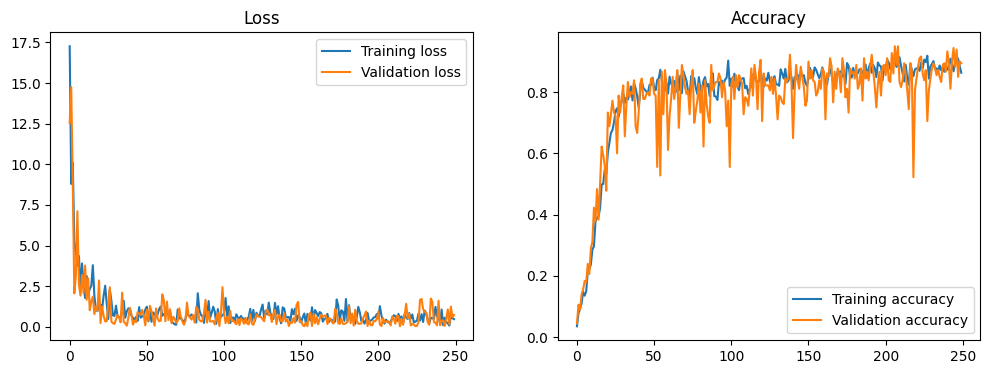

Epoch [251/1100], Loss: 0.3799985945224762, Accuracy: 0.8984126984126984 Correct: 566 Total: 630 LR: 0.00038659090909090983 -> 0.0003861372727272735
Validation Accuracy: 0.9 Validation loss: 0.41031503677368164 Correct: 162 Total: 180
Epoch [252/1100], Loss: 0.7064862847328186, Accuracy: 0.8746031746031746 Correct: 551 Total: 630 LR: 0.0003861372727272735 -> 0.00038568363636363713
Validation Accuracy: 0.85 Validation loss: 0.5844653844833374 Correct: 153 Total: 180
Epoch [253/1100], Loss: 0.26152127981185913, Accuracy: 0.9015873015873016 Correct: 568 Total: 630 LR: 0.00038568363636363713 -> 0.0003852300000000008
Validation Accuracy: 0.8944444444444445 Validation loss: 2.3280069828033447 Correct: 161 Total: 180
Epoch [254/1100], Loss: 0.5142712593078613, Accuracy: 0.9015873015873016 Correct: 568 Total: 630 LR: 0.0003852300000000008 -> 0.00038477636363636443
Validation Accuracy: 0.8666666666666667 Validation loss: 0.41524696350097656 Correct: 156 Total: 180
Epoch [255/1100], Loss: 0.2951

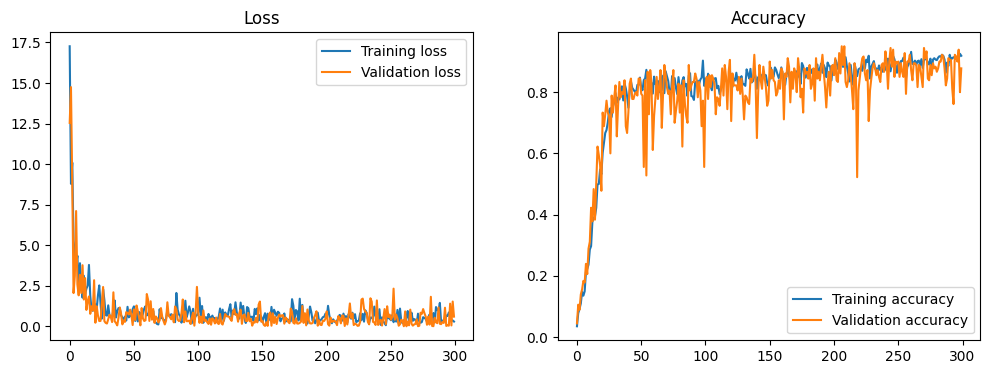

Epoch [301/1100], Loss: 0.7049606442451477, Accuracy: 0.8984126984126984 Correct: 566 Total: 630 LR: 0.0003639090909090916 -> 0.00036345545454545525
Validation Accuracy: 0.8777777777777778 Validation loss: 0.5248124003410339 Correct: 158 Total: 180
Epoch [302/1100], Loss: 0.7968632578849792, Accuracy: 0.9095238095238095 Correct: 573 Total: 630 LR: 0.00036345545454545525 -> 0.0003630018181818189
Validation Accuracy: 0.8944444444444445 Validation loss: 1.0739046335220337 Correct: 161 Total: 180
Epoch [303/1100], Loss: 0.0625872015953064, Accuracy: 0.9222222222222223 Correct: 581 Total: 630 LR: 0.0003630018181818189 -> 0.00036254818181818255
Validation Accuracy: 0.8944444444444445 Validation loss: 0.48887234926223755 Correct: 161 Total: 180
Epoch [304/1100], Loss: 0.27820244431495667, Accuracy: 0.9349206349206349 Correct: 589 Total: 630 LR: 0.00036254818181818255 -> 0.0003620945454545462
Validation Accuracy: 0.9055555555555556 Validation loss: 0.5824818015098572 Correct: 163 Total: 180
Ep

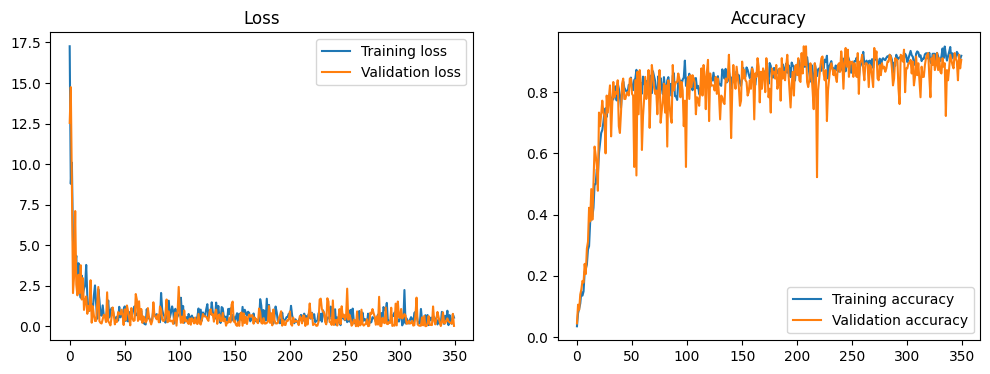

Epoch [351/1100], Loss: 0.9659461975097656, Accuracy: 0.9079365079365079 Correct: 572 Total: 630 LR: 0.0003412272727272734 -> 0.000340773636363637
Validation Accuracy: 0.9055555555555556 Validation loss: 0.34657591581344604 Correct: 163 Total: 180
Epoch [352/1100], Loss: 0.10306347161531448, Accuracy: 0.9111111111111111 Correct: 574 Total: 630 LR: 0.000340773636363637 -> 0.00034032000000000067
Validation Accuracy: 0.9166666666666666 Validation loss: 0.05302244797348976 Correct: 165 Total: 180
Epoch [353/1100], Loss: 1.122646689414978, Accuracy: 0.9238095238095239 Correct: 582 Total: 630 LR: 0.00034032000000000067 -> 0.0003398663636363643
Validation Accuracy: 0.9333333333333333 Validation loss: 0.02998751401901245 Correct: 168 Total: 180
Epoch [354/1100], Loss: 0.7636703848838806, Accuracy: 0.9222222222222223 Correct: 581 Total: 630 LR: 0.0003398663636363643 -> 0.00033941272727272797
Validation Accuracy: 0.8333333333333334 Validation loss: 0.1836889386177063 Correct: 150 Total: 180
Epoc

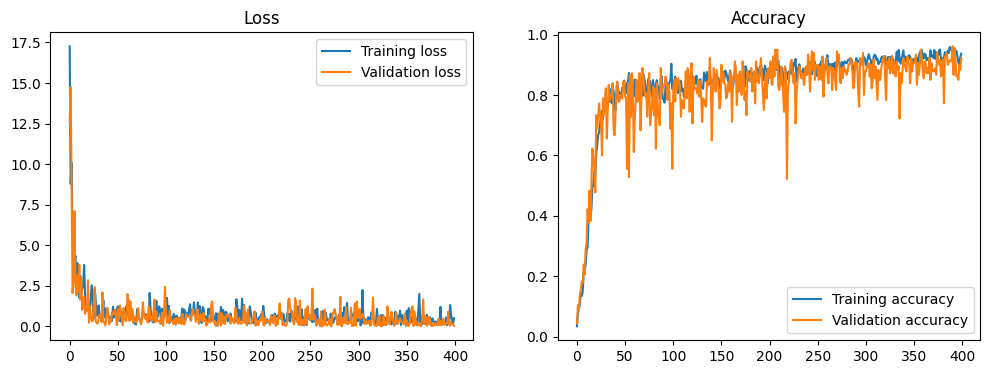

Epoch [401/1100], Loss: 0.18194061517715454, Accuracy: 0.9317460317460318 Correct: 587 Total: 630 LR: 0.00031854545454545547 -> 0.0003180918181818191
Validation Accuracy: 0.9333333333333333 Validation loss: 0.2971702814102173 Correct: 168 Total: 180
Epoch [402/1100], Loss: 0.7869507670402527, Accuracy: 0.9603174603174603 Correct: 605 Total: 630 LR: 0.0003180918181818191 -> 0.00031763818181818277
Validation Accuracy: 0.9166666666666666 Validation loss: 0.6029371619224548 Correct: 165 Total: 180
Epoch [403/1100], Loss: 0.4697631597518921, Accuracy: 0.9444444444444444 Correct: 595 Total: 630 LR: 0.00031763818181818277 -> 0.0003171845454545464
Validation Accuracy: 0.9333333333333333 Validation loss: 0.11862397193908691 Correct: 168 Total: 180
Epoch [404/1100], Loss: 0.6823916435241699, Accuracy: 0.9126984126984127 Correct: 575 Total: 630 LR: 0.0003171845454545464 -> 0.00031673090909091007
Validation Accuracy: 0.8722222222222222 Validation loss: 0.024974334985017776 Correct: 157 Total: 180


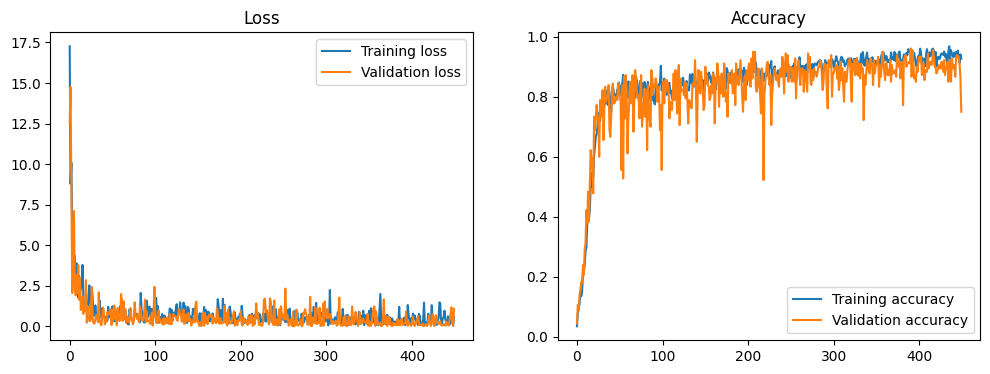

Epoch [451/1100], Loss: 0.10891873389482498, Accuracy: 0.9365079365079365 Correct: 590 Total: 630 LR: 0.00029586363636363735 -> 0.000295410000000001
Validation Accuracy: 0.9222222222222223 Validation loss: 0.27779731154441833 Correct: 166 Total: 180
Epoch [452/1100], Loss: 0.1830553561449051, Accuracy: 0.9444444444444444 Correct: 595 Total: 630 LR: 0.000295410000000001 -> 0.00029495636363636464
Validation Accuracy: 0.9222222222222223 Validation loss: 0.2812195420265198 Correct: 166 Total: 180
Epoch [453/1100], Loss: 0.809684693813324, Accuracy: 0.9428571428571428 Correct: 594 Total: 630 LR: 0.00029495636363636464 -> 0.0002945027272727283
Validation Accuracy: 0.8388888888888889 Validation loss: 0.4087944030761719 Correct: 151 Total: 180
Epoch [454/1100], Loss: 0.23684316873550415, Accuracy: 0.946031746031746 Correct: 596 Total: 630 LR: 0.0002945027272727283 -> 0.00029404909090909194
Validation Accuracy: 0.8833333333333333 Validation loss: 0.7760176658630371 Correct: 159 Total: 180
Epoch

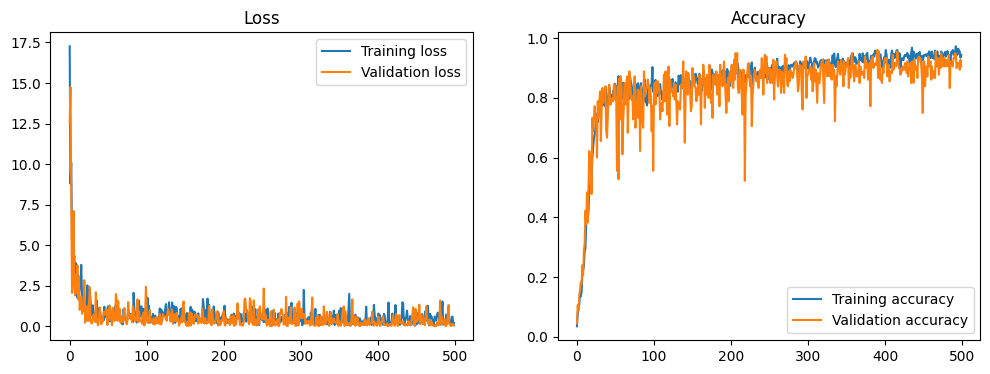

Epoch [501/1100], Loss: 0.07632039487361908, Accuracy: 0.9444444444444444 Correct: 595 Total: 630 LR: 0.00027318181818181977 -> 0.0002727281818181834
Validation Accuracy: 0.9388888888888889 Validation loss: 0.3491138517856598 Correct: 169 Total: 180
Epoch [502/1100], Loss: 0.11900126934051514, Accuracy: 0.9380952380952381 Correct: 591 Total: 630 LR: 0.0002727281818181834 -> 0.00027227454545454706
Validation Accuracy: 0.9111111111111111 Validation loss: 0.027049444615840912 Correct: 164 Total: 180
Epoch [503/1100], Loss: 0.13819989562034607, Accuracy: 0.973015873015873 Correct: 613 Total: 630 LR: 0.00027227454545454706 -> 0.0002718209090909107
Validation Accuracy: 0.95 Validation loss: 0.0824715718626976 Correct: 171 Total: 180
Epoch [504/1100], Loss: 0.3103587329387665, Accuracy: 0.9507936507936507 Correct: 599 Total: 630 LR: 0.0002718209090909107 -> 0.00027136727272727436
Validation Accuracy: 0.8944444444444445 Validation loss: 0.18208272755146027 Correct: 161 Total: 180
Epoch [505/11

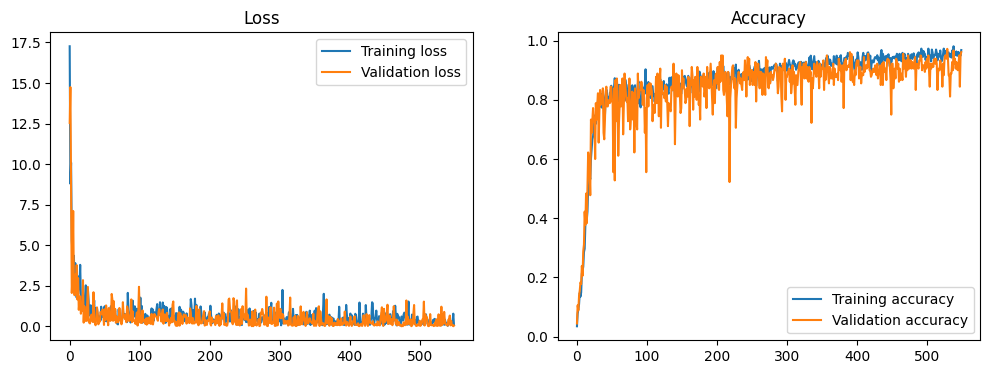

Epoch [551/1100], Loss: 0.16186371445655823, Accuracy: 0.9666666666666667 Correct: 609 Total: 630 LR: 0.000250500000000002 -> 0.00025004636363636567
Validation Accuracy: 0.8944444444444445 Validation loss: 0.26980894804000854 Correct: 161 Total: 180
Epoch [552/1100], Loss: 0.20327238738536835, Accuracy: 0.9682539682539683 Correct: 610 Total: 630 LR: 0.00025004636363636567 -> 0.0002495927272727293
Validation Accuracy: 0.9166666666666666 Validation loss: 0.05539603531360626 Correct: 165 Total: 180
Epoch [553/1100], Loss: 0.37124690413475037, Accuracy: 0.9682539682539683 Correct: 610 Total: 630 LR: 0.0002495927272727293 -> 0.00024913909090909297
Validation Accuracy: 0.9666666666666667 Validation loss: 0.16030573844909668 Correct: 174 Total: 180
Epoch [554/1100], Loss: 0.4167461693286896, Accuracy: 0.9507936507936507 Correct: 599 Total: 630 LR: 0.00024913909090909297 -> 0.00024868545454545657
Validation Accuracy: 0.9277777777777778 Validation loss: 0.16192854940891266 Correct: 167 Total: 1

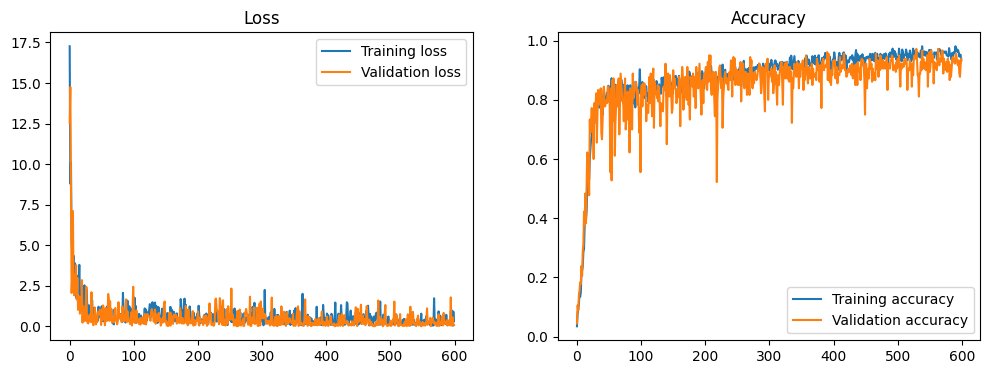

Epoch [601/1100], Loss: 0.26939722895622253, Accuracy: 0.973015873015873 Correct: 613 Total: 630 LR: 0.00022781818181818385 -> 0.00022736454545454747
Validation Accuracy: 0.95 Validation loss: 0.45728492736816406 Correct: 171 Total: 180
Epoch [602/1100], Loss: 0.7671200633049011, Accuracy: 0.9682539682539683 Correct: 610 Total: 630 LR: 0.00022736454545454747 -> 0.0002269109090909111
Validation Accuracy: 0.9333333333333333 Validation loss: 0.07947569340467453 Correct: 168 Total: 180
Epoch [603/1100], Loss: 0.17528514564037323, Accuracy: 0.9492063492063492 Correct: 598 Total: 630 LR: 0.0002269109090909111 -> 0.00022645727272727471
Validation Accuracy: 0.9333333333333333 Validation loss: 0.33488672971725464 Correct: 168 Total: 180
Epoch [604/1100], Loss: 0.7690679430961609, Accuracy: 0.9476190476190476 Correct: 597 Total: 630 LR: 0.00022645727272727471 -> 0.00022600363636363834
Validation Accuracy: 0.9388888888888889 Validation loss: 0.2929483950138092 Correct: 169 Total: 180
Epoch [605/1

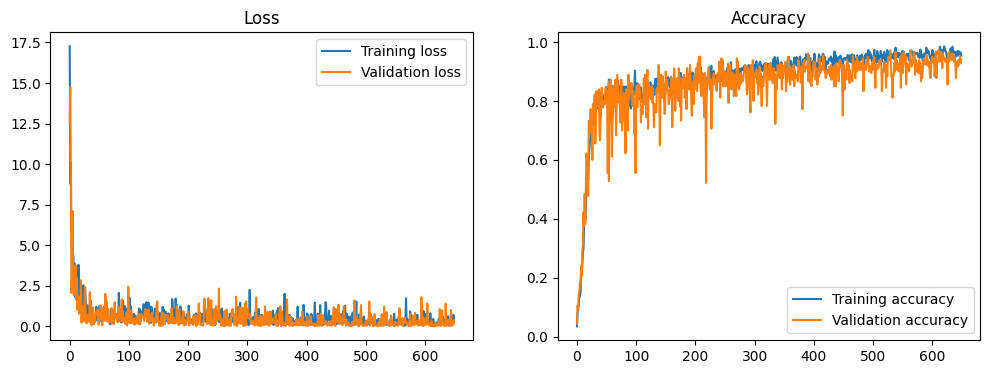

Epoch [651/1100], Loss: 0.21692733466625214, Accuracy: 0.9809523809523809 Correct: 618 Total: 630 LR: 0.0002051363636363653 -> 0.0002046827272727289
Validation Accuracy: 0.9444444444444444 Validation loss: 0.4438580274581909 Correct: 170 Total: 180
Epoch [652/1100], Loss: 0.09205649048089981, Accuracy: 0.9698412698412698 Correct: 611 Total: 630 LR: 0.0002046827272727289 -> 0.00020422909090909256
Validation Accuracy: 0.95 Validation loss: 0.7034524083137512 Correct: 171 Total: 180
Epoch [653/1100], Loss: 0.3015526533126831, Accuracy: 0.973015873015873 Correct: 613 Total: 630 LR: 0.00020422909090909256 -> 0.0002037754545454562
Validation Accuracy: 0.9444444444444444 Validation loss: 1.0129520893096924 Correct: 170 Total: 180
Epoch [654/1100], Loss: 0.06511839479207993, Accuracy: 0.9650793650793651 Correct: 608 Total: 630 LR: 0.0002037754545454562 -> 0.00020332181818181986
Validation Accuracy: 0.9555555555555556 Validation loss: 0.10038840025663376 Correct: 172 Total: 180
Epoch [655/1100]

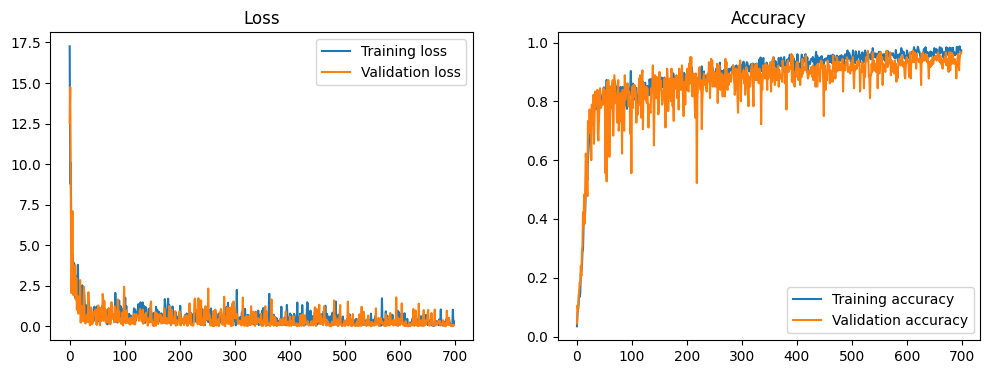

Epoch [701/1100], Loss: 0.5544769763946533, Accuracy: 0.9682539682539683 Correct: 610 Total: 630 LR: 0.000182454545454547 -> 0.00018200090909091066
Validation Accuracy: 0.9055555555555556 Validation loss: 0.1298854649066925 Correct: 163 Total: 180
Epoch [702/1100], Loss: 0.29788079857826233, Accuracy: 0.9571428571428572 Correct: 603 Total: 630 LR: 0.00018200090909091066 -> 0.0001815472727272743
Validation Accuracy: 0.9444444444444444 Validation loss: 0.2045576572418213 Correct: 170 Total: 180
Epoch [703/1100], Loss: 0.09312832355499268, Accuracy: 0.9682539682539683 Correct: 610 Total: 630 LR: 0.0001815472727272743 -> 0.00018109363636363793
Validation Accuracy: 0.9444444444444444 Validation loss: 0.20641200244426727 Correct: 170 Total: 180
Epoch [704/1100], Loss: 0.20063896477222443, Accuracy: 0.9555555555555556 Correct: 602 Total: 630 LR: 0.00018109363636363793 -> 0.00018064000000000155
Validation Accuracy: 0.9444444444444444 Validation loss: 0.16369657218456268 Correct: 170 Total: 180

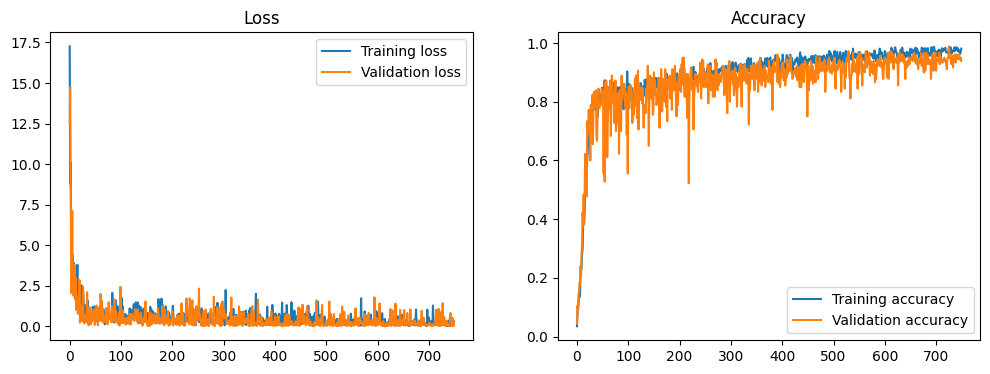

Epoch [751/1100], Loss: 0.06437567621469498, Accuracy: 0.9746031746031746 Correct: 614 Total: 630 LR: 0.0001597727272727286 -> 0.00015931909090909224
Validation Accuracy: 0.95 Validation loss: 0.16681021451950073 Correct: 171 Total: 180
Epoch [752/1100], Loss: 0.04049871489405632, Accuracy: 0.9793650793650793 Correct: 617 Total: 630 LR: 0.00015931909090909224 -> 0.00015886545454545589
Validation Accuracy: 0.9611111111111111 Validation loss: 0.017768166959285736 Correct: 173 Total: 180
Epoch [753/1100], Loss: 0.08551797270774841, Accuracy: 0.9825396825396825 Correct: 619 Total: 630 LR: 0.00015886545454545589 -> 0.0001584118181818195
Validation Accuracy: 0.9444444444444444 Validation loss: 0.018855655565857887 Correct: 170 Total: 180
Epoch [754/1100], Loss: 0.04133680462837219, Accuracy: 0.9761904761904762 Correct: 615 Total: 630 LR: 0.0001584118181818195 -> 0.00015795818181818313
Validation Accuracy: 0.9722222222222222 Validation loss: 0.05499394237995148 Correct: 175 Total: 180
Epoch [

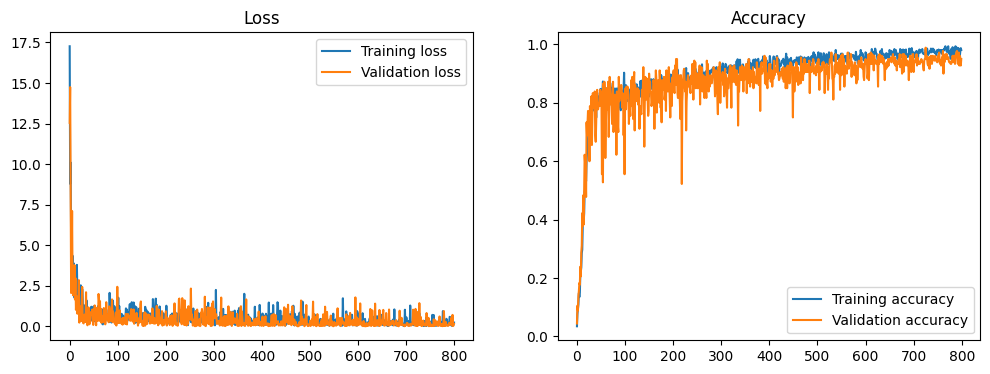

Epoch [801/1100], Loss: 0.1142432913184166, Accuracy: 0.9793650793650793 Correct: 617 Total: 630 LR: 0.00013709090909091036 -> 0.000136637272727274
Validation Accuracy: 0.9666666666666667 Validation loss: 0.004911181051284075 Correct: 174 Total: 180
Epoch [802/1100], Loss: 0.13643939793109894, Accuracy: 0.9761904761904762 Correct: 615 Total: 630 LR: 0.000136637272727274 -> 0.00013618363636363765
Validation Accuracy: 0.9444444444444444 Validation loss: 0.21772584319114685 Correct: 170 Total: 180
Epoch [803/1100], Loss: 0.04557260498404503, Accuracy: 0.9761904761904762 Correct: 615 Total: 630 LR: 0.00013618363636363765 -> 0.00013573000000000128
Validation Accuracy: 0.95 Validation loss: 0.07466986775398254 Correct: 171 Total: 180
Epoch [804/1100], Loss: 0.11196675151586533, Accuracy: 0.9857142857142858 Correct: 621 Total: 630 LR: 0.00013573000000000128 -> 0.0001352763636363649
Validation Accuracy: 0.9555555555555556 Validation loss: 0.09892675280570984 Correct: 172 Total: 180
Epoch [805/

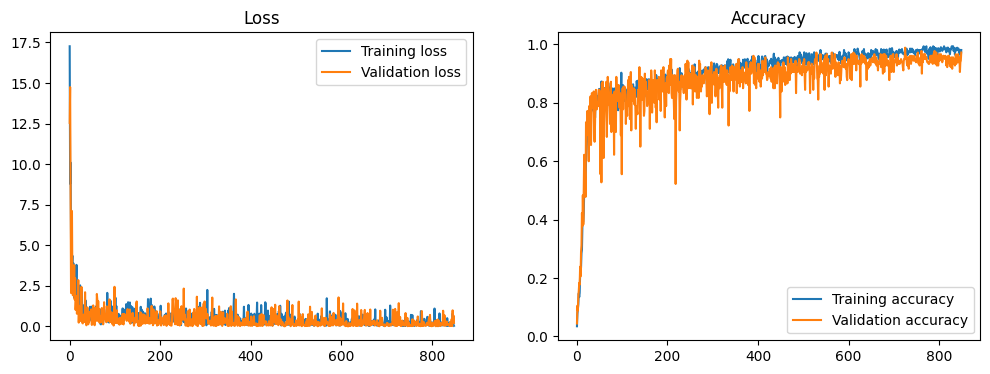

Epoch [851/1100], Loss: 0.18317021429538727, Accuracy: 0.9920634920634921 Correct: 625 Total: 630 LR: 0.00011440909090909198 -> 0.00011395545454545561
Validation Accuracy: 0.9888888888888889 Validation loss: 0.29071319103240967 Correct: 178 Total: 180
Epoch [852/1100], Loss: 0.027748143300414085, Accuracy: 0.9841269841269841 Correct: 620 Total: 630 LR: 0.00011395545454545561 -> 0.00011350181818181925
Validation Accuracy: 0.9666666666666667 Validation loss: 0.29251572489738464 Correct: 174 Total: 180
Epoch [853/1100], Loss: 0.06863032281398773, Accuracy: 0.9809523809523809 Correct: 618 Total: 630 LR: 0.00011350181818181925 -> 0.00011304818181818287
Validation Accuracy: 0.9388888888888889 Validation loss: 0.1745581328868866 Correct: 169 Total: 180
Epoch [854/1100], Loss: 0.11501703411340714, Accuracy: 0.9793650793650793 Correct: 617 Total: 630 LR: 0.00011304818181818287 -> 0.0001125945454545465
Validation Accuracy: 0.9666666666666667 Validation loss: 0.05820661038160324 Correct: 174 Tota

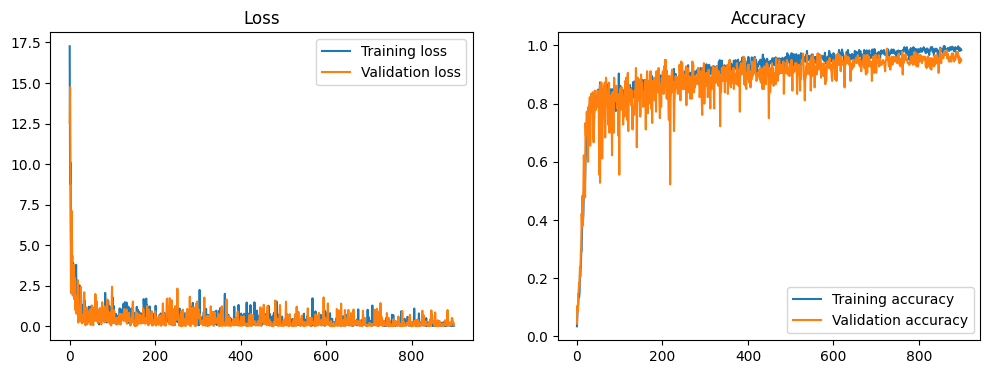

Epoch [901/1100], Loss: 0.09417315572500229, Accuracy: 0.9841269841269841 Correct: 620 Total: 630 LR: 9.172727272727361e-05 -> 9.127363636363725e-05
Validation Accuracy: 0.9611111111111111 Validation loss: 0.09700105339288712 Correct: 173 Total: 180
Epoch [902/1100], Loss: 0.1536373794078827, Accuracy: 0.9920634920634921 Correct: 625 Total: 630 LR: 9.127363636363725e-05 -> 9.082000000000088e-05
Validation Accuracy: 0.9722222222222222 Validation loss: 0.02103707566857338 Correct: 175 Total: 180
Epoch [903/1100], Loss: 0.0772467628121376, Accuracy: 0.9936507936507937 Correct: 626 Total: 630 LR: 9.082000000000088e-05 -> 9.036636363636452e-05
Validation Accuracy: 0.95 Validation loss: 0.14296278357505798 Correct: 171 Total: 180
Epoch [904/1100], Loss: 0.04504997655749321, Accuracy: 0.9825396825396825 Correct: 619 Total: 630 LR: 9.036636363636452e-05 -> 8.991272727272815e-05
Validation Accuracy: 0.9555555555555556 Validation loss: 0.09419525414705276 Correct: 172 Total: 180
Epoch [905/1100]

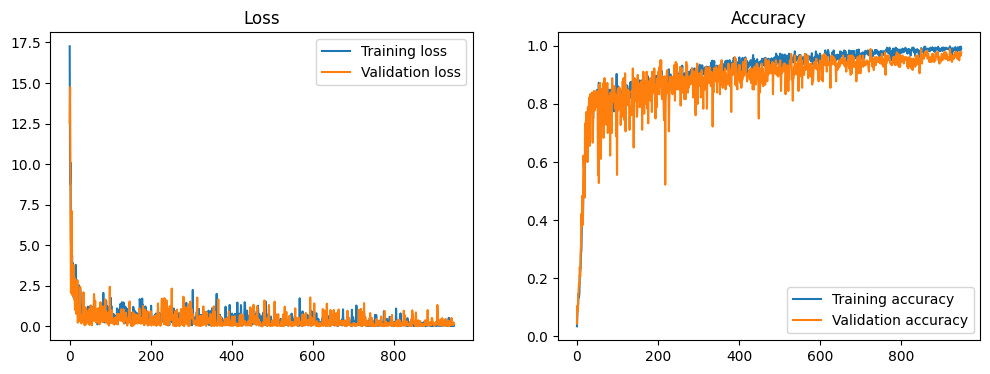

Epoch [951/1100], Loss: 0.6349012851715088, Accuracy: 0.9936507936507937 Correct: 626 Total: 630 LR: 6.904545454545533e-05 -> 6.859181818181895e-05
Validation Accuracy: 0.95 Validation loss: 0.25468185544013977 Correct: 171 Total: 180
Epoch [952/1100], Loss: 0.36938369274139404, Accuracy: 0.9777777777777777 Correct: 616 Total: 630 LR: 6.859181818181895e-05 -> 6.813818181818258e-05
Validation Accuracy: 0.9666666666666667 Validation loss: 0.2884267568588257 Correct: 174 Total: 180
Epoch [953/1100], Loss: 0.016773315146565437, Accuracy: 0.9888888888888889 Correct: 623 Total: 630 LR: 6.813818181818258e-05 -> 6.768454545454622e-05
Validation Accuracy: 0.9611111111111111 Validation loss: 0.09006266295909882 Correct: 173 Total: 180
Epoch [954/1100], Loss: 0.022770114243030548, Accuracy: 0.9920634920634921 Correct: 625 Total: 630 LR: 6.768454545454622e-05 -> 6.723090909090986e-05
Validation Accuracy: 0.9777777777777777 Validation loss: 0.04562786594033241 Correct: 176 Total: 180
Epoch [955/110

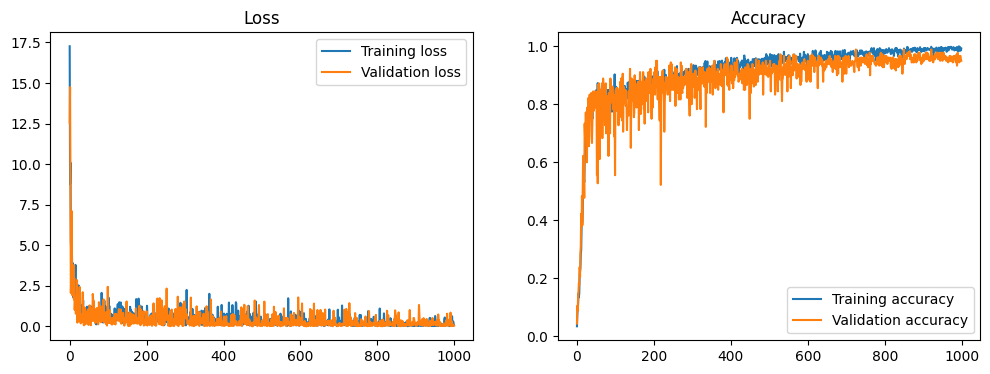

Epoch [1001/1100], Loss: 0.20989227294921875, Accuracy: 0.9904761904761905 Correct: 624 Total: 630 LR: 4.6363636363636885e-05 -> 4.591000000000052e-05
Validation Accuracy: 0.9611111111111111 Validation loss: 0.21275512874126434 Correct: 173 Total: 180
Epoch [1002/1100], Loss: 0.020236028358340263, Accuracy: 0.9888888888888889 Correct: 623 Total: 630 LR: 4.591000000000052e-05 -> 4.545636363636415e-05
Validation Accuracy: 0.9555555555555556 Validation loss: 0.10277234017848969 Correct: 172 Total: 180
Epoch [1003/1100], Loss: 0.04477834701538086, Accuracy: 0.9904761904761905 Correct: 624 Total: 630 LR: 4.545636363636415e-05 -> 4.500272727272778e-05
Validation Accuracy: 0.9666666666666667 Validation loss: 0.2798745632171631 Correct: 174 Total: 180
Epoch [1004/1100], Loss: 0.07816974073648453, Accuracy: 0.9920634920634921 Correct: 625 Total: 630 LR: 4.500272727272778e-05 -> 4.4549090909091415e-05
Validation Accuracy: 0.9388888888888889 Validation loss: 0.05389484018087387 Correct: 169 Total

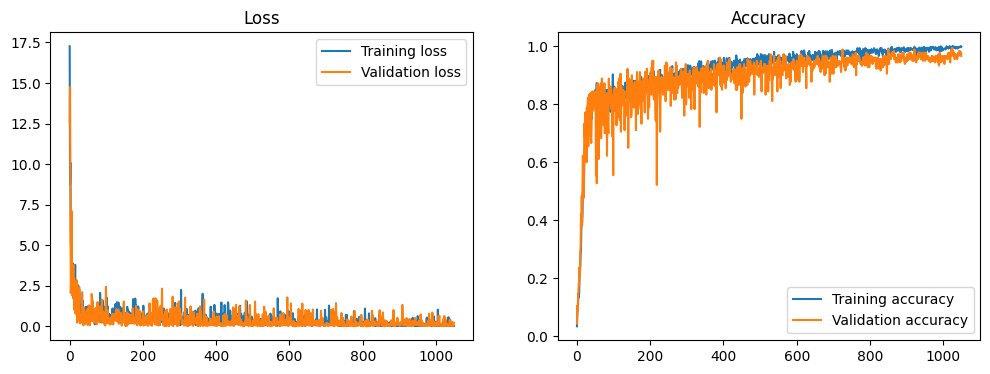

Epoch [1051/1100], Loss: 0.01719093881547451, Accuracy: 0.9984126984126984 Correct: 629 Total: 630 LR: 2.3681818181818428e-05 -> 2.322818181818206e-05
Validation Accuracy: 0.9833333333333333 Validation loss: 0.11481808125972748 Correct: 177 Total: 180
Epoch [1052/1100], Loss: 0.05167468264698982, Accuracy: 0.9936507936507937 Correct: 626 Total: 630 LR: 2.322818181818206e-05 -> 2.2774545454545693e-05
Validation Accuracy: 0.9722222222222222 Validation loss: 0.05036821961402893 Correct: 175 Total: 180
Epoch [1053/1100], Loss: 0.011777329258620739, Accuracy: 0.9968253968253968 Correct: 628 Total: 630 LR: 2.2774545454545693e-05 -> 2.2320909090909325e-05
Validation Accuracy: 0.9833333333333333 Validation loss: 0.22801482677459717 Correct: 177 Total: 180
Epoch [1054/1100], Loss: 0.3026881515979767, Accuracy: 0.9968253968253968 Correct: 628 Total: 630 LR: 2.2320909090909325e-05 -> 2.1867272727272958e-05
Validation Accuracy: 0.9833333333333333 Validation loss: 0.23001085221767426 Correct: 177 T

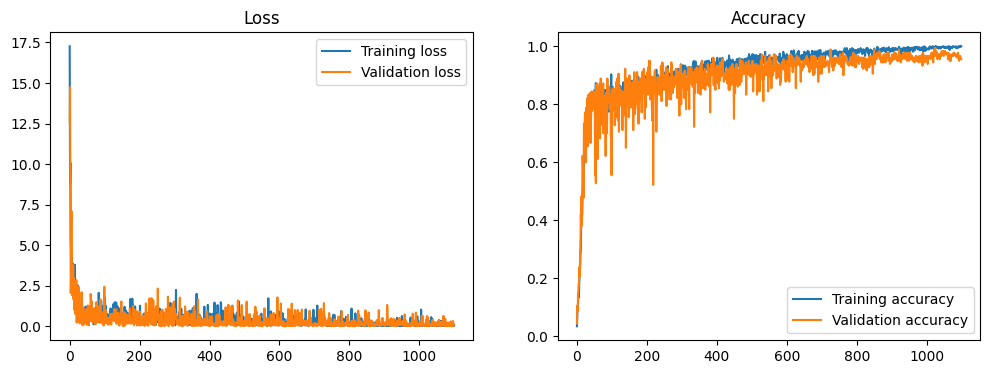

In [28]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = torch.squeeze(labels).to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = cost(outputs, torch.squeeze(labels))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()
        
        previous_lr = scheduler.get_last_lr()[0]
        scheduler.step()
        next_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {correct/total}", "Correct:", correct, "Total:", total, f"LR: {previous_lr} -> {next_lr}")
        train_losses.append(loss.item())
        train_accuracies.append(correct/total)

        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = torch.squeeze(labels).to(device)
                outputs = model(inputs)
                
                loss = cost(outputs, torch.squeeze(labels))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f"Validation Accuracy: {correct/total}", f"Validation loss: {loss}", "Correct:", correct, "Total:", total)
            val_losses.append(loss.item())
            val_accuracies.append(correct/total)
        
        if epoch != 0 and (epoch % 50 == 49):
            plot_results(train_losses, train_accuracies, val_losses, val_accuracies)
        if epoch > 2 and val_accuracies[-1] > max(val_accuracies[:-1]):
            save_model(model, best_model_path)

In [29]:
save_model(model, model_path)

### Results

In [30]:
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

MyCoAtNet(
  (0): Sequential(
    (0): Stem(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    )
  )
  (1): Sequential(
    (0): DownsamplingMBConv(
      (mb_conv): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): GELU(approximate='none')
        (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
        (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): GELU(approximate='none')
        (7): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
    

In [31]:
print("Best validation acc: ", max(val_accuracies))
print("Last validation acc: ", val_accuracies[-1])

Best validation acc:  0.9944444444444445
Last validation acc:  0.9555555555555556


In [32]:
# Generate the alphabet (0-9 and A-Z)
digits = [str(digit) for digit in range(10)]
alphabet = [chr(ascii_code) for ascii_code in range(ord('A'), ord('Z') + 1)]

# Combine digits and alphabet
all_characters = digits + alphabet

# Create the label dictionary
label_dict = {i: all_characters[i] for i in range(len(all_characters))}

# Print the label dictionary
print(label_dict)


{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}


In [33]:
# Adapted from My_CoAtNet
predictions_path = 'predictions-zoom.csv'

def predict(data_loader):

    original_labels = []
    predicted_labels = []

    correct = 0
    total = 0
    
    model.eval()
    
    for inputs, labels in data_loader:

        inputs = inputs.to(device)
        labels = torch.squeeze(labels).to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
      
        original_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    prediction_df = pd.DataFrame({"predicted_labels": [label_dict[pred] for pred in predicted_labels], "true_labels": [label_dict[label] for label in original_labels]})
    prediction_df.to_csv(predictions_path)

    print(f"Test Accuracy: {correct/total}")
    pd.set_option('display.max_rows', None)
    pd.set_option("display.max_columns", None)
    display(prediction_df.T)
    
    print (metrics.accuracy_score(original_labels, predicted_labels))
    print (metrics.classification_report(original_labels, predicted_labels))
    
    return confusion_matrix(original_labels, predicted_labels)

### Test accuracy

In [34]:
cm = predict(test_dataloader)

Test Accuracy: 0.9666666666666667


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
predicted_labels,J,P,L,K,U,T,C,M,1,U,7,Y,9,F,T,C,N,I,I,4,S,B,U,Q,8,L,P,3,4,D,D,9,3,N,H,O,6,2,R,A,R,Z,5,6,U,B,W,9,G,L,F,1,5,N,K,5,0,3,Y,E,E,T,A,X,I,2,Q,P,X,V,O,W,Q,W,S,0,U,D,H,7,Z,Z,8,G,G,M,E,V,B,1
true_labels,J,P,L,K,Y,T,C,M,1,U,7,Y,9,F,T,C,N,I,I,4,S,M,U,Q,8,L,P,3,4,D,D,9,3,N,H,O,6,2,R,A,R,Z,5,6,U,B,W,9,G,L,F,1,5,N,K,5,0,3,Y,E,E,T,A,X,I,2,Q,P,X,V,O,W,Q,W,S,0,J,D,H,7,Z,Z,8,G,G,M,E,V,B,1


0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         2
          11       0.67      1.00      0.80         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         3
        

### Confusion matrix

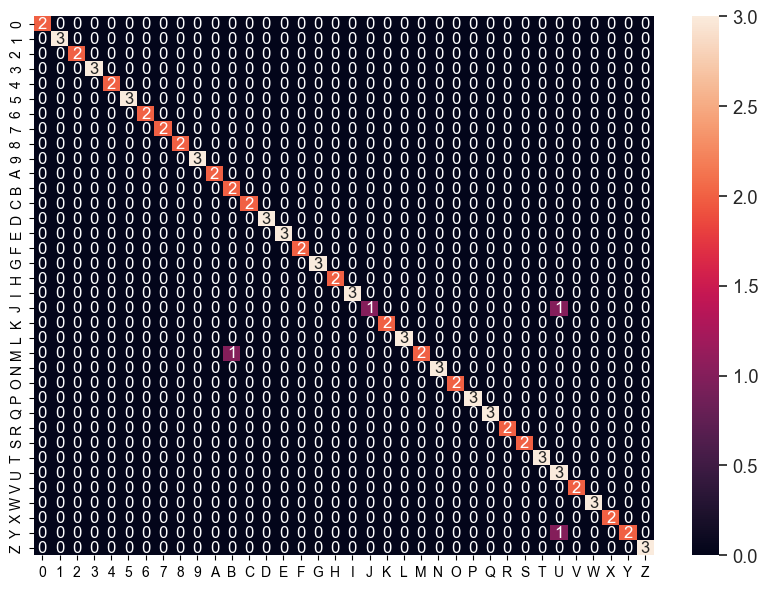

In [35]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=all_characters, 
                yticklabels=all_characters,
                annot_kws={"size": 12}
                )
fig.savefig("confusion_matrix_CoAtNet-1-zoom")